In [33]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 512  # the generated image resolution
    resolution = 512
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    max_train_steps = 15000
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    dataset_name = 'ffhq256'
    output_dir = 'checkpoints/ffhq256'  # the model namy locally and on the HF Hub
    train_data_dir = './dataset/ffhq256/images/'
    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

args = TrainingConfig()

In [30]:
from datasets import load_dataset
dataset = load_dataset('imagefolder', data_dir=args.train_data_dir)

Resolving data files:   0%|          | 0/70001 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/AD/xiw136/.cache/huggingface/datasets/imagefolder/default-9588da85d40737f0/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 70000
    })
})

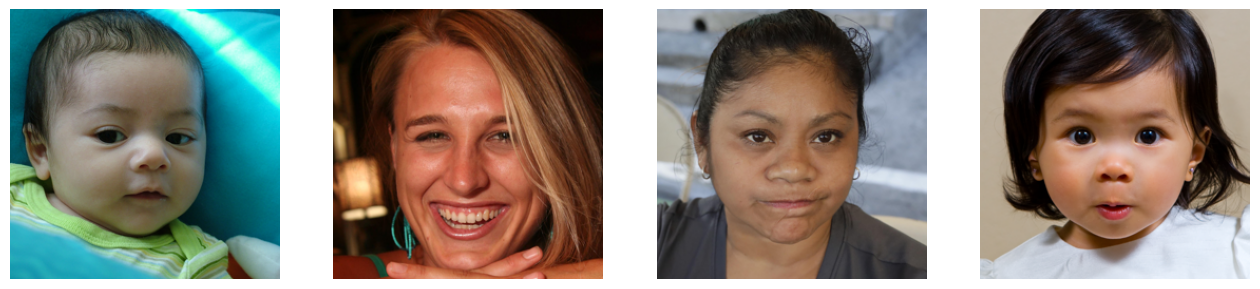

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

In [9]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

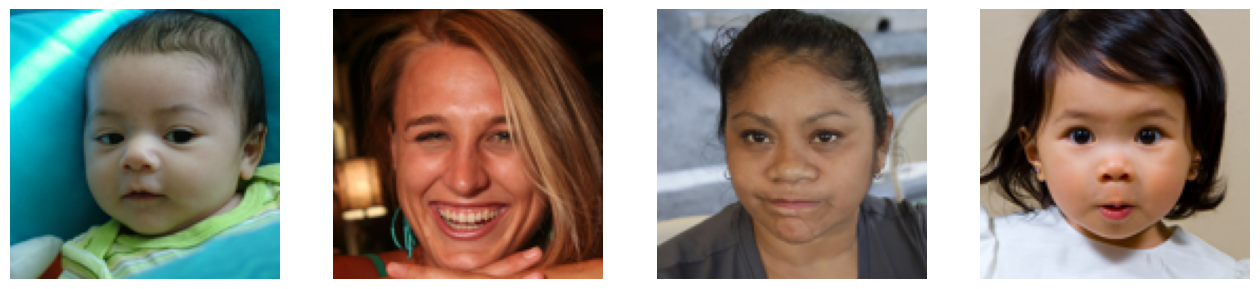

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset['train'][:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [1]:
from dataclasses import dataclass
import torch

@dataclass
class TrainingConfig:
    pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
    resolution = 256  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_train_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 1
    save_model_epochs = 1
    input_perturbation = 0

    weight_dtype = torch.bfloat16
    dataloader_num_workers = 1
    lr_scheduler = 'constant'
    
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    dataset_name = 'ffhq256'
    train_data_dir = './dataset/ffhq256/images/'
    output_dir = 'checkpoints/ffhq256'  # the model namy locally and on the HF Hub
    logging_dir = 'log'
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

    image_column = None
    caption_column = None
    
args = TrainingConfig()

In [63]:
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
noise_scheduler = DDPMScheduler.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="scheduler"#, torch_dtype=torch.float16
    )
tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer"#, torch_dtype=torch.float16
    )
text_encoder = CLIPTextModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="text_encoder"#, torch_dtype=torch.float16
    )
vae = AutoencoderKL.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="vae"#, torch_dtype=torch.float16
    )
'''unet = UNet2DConditionModel.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="unet"#, torch_dtype=torch.float16
    )'''
unet = UNet2DConditionModel(
    sample_size=64,
    in_channels=4,
    out_channels=4,
    down_block_types=('CrossAttnDownBlock2D','CrossAttnDownBlock2D','CrossAttnDownBlock2D','DownBlock2D'),
    mid_block_type= "UNetMidBlock2DCrossAttn",
    up_block_types = ("UpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"),
    block_out_channels= (320, 640, 1280, 1280),
    cross_attention_dim = 768,
)

vae.requires_grad_(False)
text_encoder.requires_grad_(False)

In [60]:
from torchvision import transforms
import accelerate
import numpy as np
import random
import torch

DATASET_NAME_MAPPING = {
    "ffhq256": ("image", "text"),  # args.dataset_name = "ffhq256"
}

column_names = dataset["train"].column_names

dataset_columns = DATASET_NAME_MAPPING.get(args.dataset_name, None)
if args.image_column is None:
    image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
else:
    image_column = args.image_column
    if image_column not in column_names:
        raise ValueError(
            f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
        )
if args.caption_column is None:
    caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
else:
    caption_column = args.caption_column
    if caption_column not in column_names:
        raise ValueError(
            f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
        )
        
train_transforms = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(
            captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

dataset["train"] = dataset["train"].shuffle(seed=args.seed)
# Set the training transforms
train_dataset = dataset["train"].with_transform(preprocess_train)

In [61]:
import torch
# DataLoaders creation:
def collate_fn(examples):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
        input_ids = torch.stack([example["input_ids"] for example in examples])
        return {"pixel_values": pixel_values, "input_ids": input_ids}

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)


In [62]:
for batch in train_dataloader:
    break
print(f"pixel_values: {batch['pixel_values'].shape} \ninput_ids: {batch['input_ids'].shape}")

pixel_values: torch.Size([16, 3, 256, 256]) 
input_ids: torch.Size([16, 77])


In [64]:
device = 'cuda:0'
text_encoder.to(device, dtype=args.weight_dtype)
vae.to(device, dtype=args.weight_dtype)
unet.to(device, dtype=args.weight_dtype)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features

In [66]:
vae.encode(batch['pixel_values'].to(device, dtype=args.weight_dtype))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 vae.encode(batch['pixel_values'].to(device, dtype=args.weight_dtype))                        │
│   2                                                                                              │
│                                                                                                  │
│ /home/AD/xiw136/anaconda3/envs/ldm/lib/python3.8/site-packages/diffusers/utils/accelerate_utils. │
│ py:46 in wrapper                                                                                 │
│                                                                                                  │
│   43 │   def wrapper(self, *args, **kwargs):                                                     │
│   44 │   │   if hasattr(self, "_hf_hook") and hasattr(self._hf_hook, "pre_forward"):             │
│   45 │   │   │   self._hf_hook.pre_forward(self)                                                 │
│ ❱ 46 │   │   return method(self, *args, **kwargs)                                                │
│   47 │                                                                                           │
│   48 │   return wrapper                                                                          │
│   49                                                                                             │
│                                                                                                  │
│ /home/AD/xiw136/anaconda3/envs/ldm/lib/python3.8/site-packages/diffusers/models/autoencoder_kl.p │
│ y:236 in encode                                                                                  │
│                                                                                                  │
│   233 │   │   │   encoded_slices = [self.encoder(x_slice) for x_slice in x.split(1)]             │
│   234 │   │   │   h = torch.cat(encoded_slices)                                                  │
│   235 │   │   else:                                                                              │
│ ❱ 236 │   │   │   h = self.encoder(x)                                                            │
│   237 │   │                                                                                      │
│   238 │   │   moments = self.quant_conv(h)                                                       │
│   239 │   │   posterior = DiagonalGaussianDistribution(moments)                                  │
│                                                                                                  │
│ /home/AD/xiw136/anaconda3/envs/ldm/lib/python3.8/site-packages/torch/nn/modules/module.py:1110   │
│ in _call_impl                                                                                    │
│                                                                                                  │
│   1107 │   │   # this function, and just call forward.                                           │
│   1108 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_hooks o  │
│   1109 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1110 │   │   │   return forward_call(*input, **kwargs)                                         │
│   1111 │   │   # Do not call functions when jit is used                                          │
│   1112 │   │   full_backward_hooks, non_full_backward_hooks = [], []                             │
│   1113 │   │   if self._backward_hooks or _global_backward_hooks:                                │
│                                                                                                  │
│ /home/AD/xiw136/anaconda3/envs/ldm/lib/python3.8/site-packa

In [ ]:
from diffusers.optimization import get_scheduler

optimizer_cls = torch.optim.AdamW
optimizer = optimizer_cls(
        unet.parameters(),
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

# Without CLIP Loss

In [ ]:
import torch.nn.functional as F

for epoch in range(args.num_train_epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Convert images to latent space
        latents = vae.encode(batch["pixel_values"].to(args.weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor # For diffusion use

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        '''if args.noise_offset:
            # https://www.crosslabs.org//blog/diffusion-with-offset-noise
            noise += args.noise_offset * torch.randn(
                (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
            )'''
        if args.input_perturbation:
            new_noise = noise + args.input_perturbation * torch.randn_like(noise)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        if args.input_perturbation:
            noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
        else:
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]

        # Get the target for loss depending on the prediction type
        if args.prediction_type is not None:
            # set prediction_type of scheduler if defined
            noise_scheduler.register_to_config(prediction_type=args.prediction_type)

        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        #if args.snr_gamma is None:
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
        '''else:
            # Compute loss-weights as per Section 3.4 of https://arxiv.org/abs/2303.09556.
            # Since we predict the noise instead of x_0, the original formulation is slightly changed.
            # This is discussed in Section 4.2 of the same paper.
            snr = compute_snr(timesteps)
            mse_loss_weights = (
                torch.stack([snr, args.snr_gamma * torch.ones_like(timesteps)], dim=1).min(dim=1)[0] / snr
            )
            # We first calculate the original loss. Then we mean over the non-batch dimensions and
            # rebalance the sample-wise losses with their respective loss weights.
            # Finally, we take the mean of the rebalanced loss.
            loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
            loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
            loss = loss.mean()'''

        # Gather the losses across all processes for logging (if we use distributed training).
        #avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
        train_loss += loss.item() 

        # Backpropagate
        loss.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()


# With CLIP Loss

In [ ]:
from transformers import CLIPVisionModel
clip_image_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
import torch.nn.functional as F

for epoch in range(args.num_train_epochs):
    unet.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        # Convert images to latent space
        latents = vae.encode(batch["pixel_values"].to(args.weight_dtype)).latent_dist.sample()
        latents = latents * vae.config.scaling_factor # For diffusion use

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        '''if args.noise_offset:
            # https://www.crosslabs.org//blog/diffusion-with-offset-noise
            noise += args.noise_offset * torch.randn(
                (latents.shape[0], latents.shape[1], 1, 1), device=latents.device
            )'''
        if args.input_perturbation:
            new_noise = noise + args.input_perturbation * torch.randn_like(noise)
        bsz = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
        timesteps = timesteps.long()

        # Add noise to the latents according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        if args.input_perturbation:
            noisy_latents = noise_scheduler.add_noise(latents, new_noise, timesteps)
        else:
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get the text embedding for conditioning
        encoder_hidden_states = text_encoder(batch["input_ids"])[0]

        # Get the target for loss depending on the prediction type
        if args.prediction_type is not None:
            # set prediction_type of scheduler if defined
            noise_scheduler.register_to_config(prediction_type=args.prediction_type)

        if noise_scheduler.config.prediction_type == "epsilon":
            target = noise
        elif noise_scheduler.config.prediction_type == "v_prediction":
            target = noise_scheduler.get_velocity(latents, noise, timesteps)
        else:
            raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

        # Predict the noise residual and compute loss
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        #if args.snr_gamma is None:
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        train_loss += loss.item() # TODO: /batch_size

        # Backpropagate
        loss.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()


In [18]:
sample_image = dataset['train'][0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


In [19]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

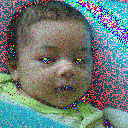

In [20]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [21]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [22]:
from diffusers.optimization import get_cosine_schedule_with_warmup
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * args.num_epochs),
)

In [ ]:
from diffusers import DDPMPipeline
import os
import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

In [ ]:
from accelerate import notebook_launcher
arguments = (args, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, arguments, num_processes=1)

In [ ]:
import glob

sample_images = sorted(glob.glob(f"{args.output_dir}/samples/*.png"))
Image.open(sample_images[-1])